imports

In [2]:
import os
import random
import numpy as np
from io import BytesIO

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf

from ipywidgets import widgets

inspecting the training dataset

In [4]:
BASE_DIR = './rps'

rock_dir = os.path.join(BASE_DIR, 'rock')
paper_dir = os.path.join(BASE_DIR, 'paper')
scissors_dir = os.path.join(BASE_DIR, 'scissors')

print(f'total training rock images: {len(os.listdir(rock_dir))}')
print(f'total training paper images: {len(os.listdir(paper_dir))}')
print(f'total training scissors images: {len(os.listdir(scissors_dir))}')

rock_files = os.listdir(rock_dir)
paper_files = os.listdir(paper_dir)
scissors_files = os.listdir(scissors_dir)

total training rock images: 840
total training paper images: 840
total training scissors images: 840


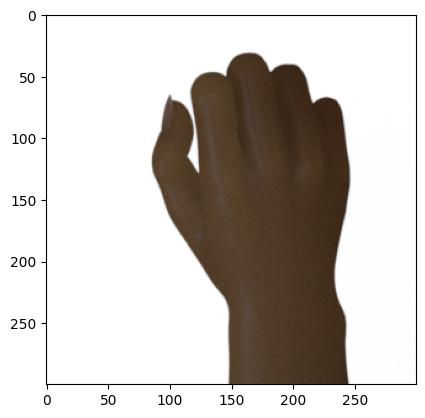

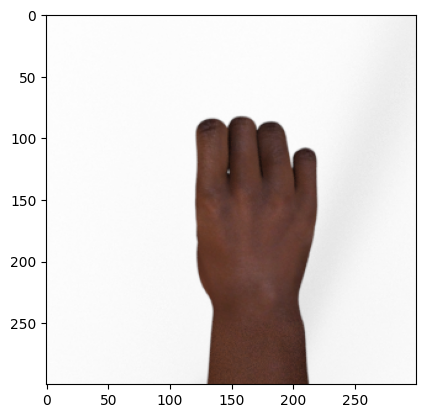

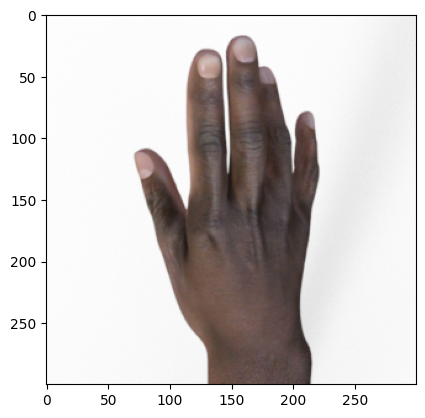

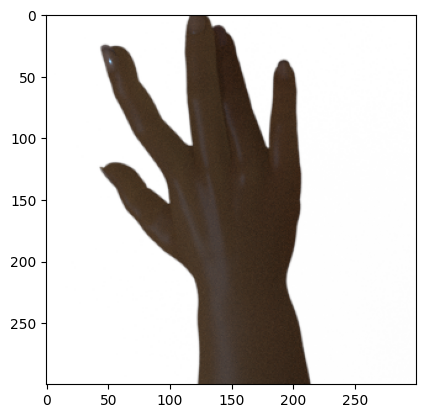

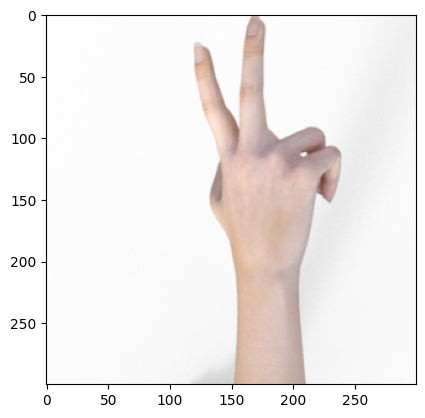

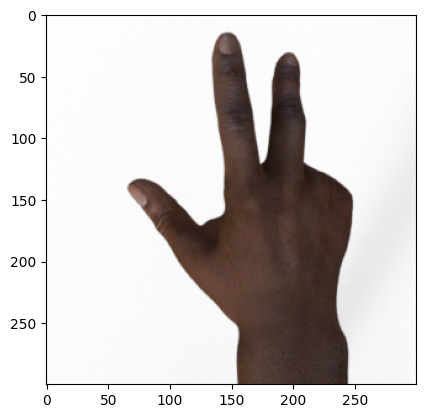

In [ ]:
next_rock = [os.path.join(rock_dir, fname)
             for fname in random.sample(rock_files, k=2)]
next_paper = [os.path.join(paper_dir, fname)
              for fname in random.sample(paper_files, k=2)]
next_scissors = [os.path.join(scissors_dir, fname)
                 for fname in random.sample(scissors_files, k=2)]

for i, img_path in enumerate(next_rock+next_paper+next_scissors):
    img = mpimg.imread(img_path)
    plt.imshow(img)
    plt.show()

constructing the model

In [6]:
model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(150, 150, 3)),
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

I0000 00:00:1753798347.709205   10363 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5224 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [7]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 148, 148, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     3,211,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,473,475 (13.25 MB)

 Trainable params: 3,473,475 (13.25 MB)

 Non-trainable params: 0 (0.00 B)

pre-processing images

In [8]:
TRAINING_DIR = "./rps"
VALIDATION_DIR = "./rps-test-set"

train_dataset = tf.keras.utils.image_dataset_from_directory(
    TRAINING_DIR,
    image_size=(150, 150),
    batch_size=32,
    label_mode='categorical'
    )

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    VALIDATION_DIR,
    image_size=(150, 150),
    batch_size=32,
    label_mode='categorical'
    )

SHUFFLE_BUFFER_SIZE = 1000
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE

train_dataset_final = (train_dataset
                       .cache()
                       .shuffle(SHUFFLE_BUFFER_SIZE)
                       .prefetch(PREFETCH_BUFFER_SIZE)
                       )

validation_dataset_final = (validation_dataset
                            .cache()
                            .prefetch(PREFETCH_BUFFER_SIZE)
                            )

Found 2520 files belonging to 3 classes.
Found 372 files belonging to 3 classes.


preparing model for training

In [9]:
data_augmentation = tf.keras.Sequential([
    tf.keras.Input(shape=(150, 150, 3)),
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.4),
    tf.keras.layers.RandomTranslation(0.2,0.2),
    tf.keras.layers.RandomContrast(0.4),
    tf.keras.layers.RandomZoom(0.2)
    ])

model_with_aug = tf.keras.models.Sequential([
    data_augmentation,
    model
])

In [10]:
model_with_aug.compile(loss = 'categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

actual training

In [11]:
history = model_with_aug.fit(
    train_dataset_final,
    epochs=25,
    validation_data = validation_dataset_final,
    verbose = 2
)

Epoch 1/25


I0000 00:00:1753798516.528731   14639 cuda_dnn.cc:529] Loaded cuDNN version 91002


79/79 - 8s - 101ms/step - accuracy: 0.3504 - loss: 1.1199 - val_accuracy: 0.3333 - val_loss: 1.0915
Epoch 2/25
79/79 - 2s - 29ms/step - accuracy: 0.3806 - loss: 1.0894 - val_accuracy: 0.6183 - val_loss: 0.9498
Epoch 3/25
79/79 - 2s - 29ms/step - accuracy: 0.4504 - loss: 1.0542 - val_accuracy: 0.5672 - val_loss: 0.8071
Epoch 4/25
79/79 - 2s - 29ms/step - accuracy: 0.5480 - loss: 0.9185 - val_accuracy: 0.7903 - val_loss: 0.6075
Epoch 5/25
79/79 - 2s - 28ms/step - accuracy: 0.6472 - loss: 0.7664 - val_accuracy: 0.8602 - val_loss: 0.3892
Epoch 6/25
79/79 - 2s - 28ms/step - accuracy: 0.7306 - loss: 0.6385 - val_accuracy: 0.8629 - val_loss: 0.3041
Epoch 7/25
79/79 - 2s - 28ms/step - accuracy: 0.7758 - loss: 0.5736 - val_accuracy: 0.8952 - val_loss: 0.2128
Epoch 8/25
79/79 - 2s - 29ms/step - accuracy: 0.8087 - loss: 0.4668 - val_accuracy: 0.8925 - val_loss: 0.2238
Epoch 9/25
79/79 - 2s - 29ms/step - accuracy: 0.8440 - loss: 0.3995 - val_accuracy: 0.9005 - val_loss: 0.1888
Epoch 10/25
79/79 - 

plots

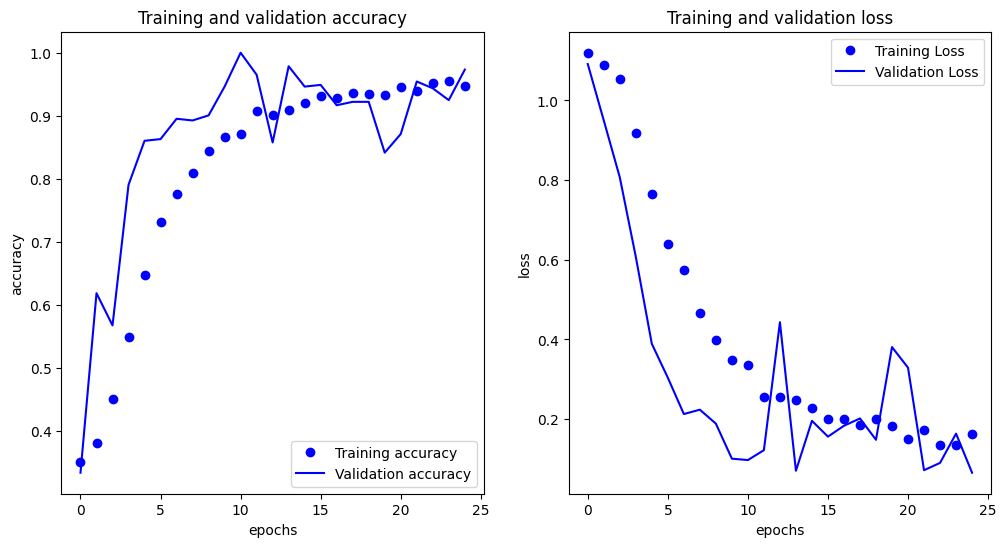

In [12]:
def plot_loss_acc(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  fig, ax = plt.subplots(1,2, figsize=(12, 6))
  ax[0].plot(epochs, acc, 'bo', label='Training accuracy')
  ax[0].plot(epochs, val_acc, 'b', label='Validation accuracy')
  ax[0].set_title('Training and validation accuracy')
  ax[0].set_xlabel('epochs')
  ax[0].set_ylabel('accuracy')
  ax[0].legend()

  ax[1].plot(epochs, loss, 'bo', label='Training Loss')
  ax[1].plot(epochs, val_loss, 'b', label='Validation Loss')
  ax[1].set_title('Training and validation loss')
  ax[1].set_xlabel('epochs')
  ax[1].set_ylabel('loss')
  ax[1].legend()

  plt.show()

plot_loss_acc(history)

model prediction

In [ ]:
uploader = widgets.FileUpload(accept="image/*", multiple=True)
display(uploader)
out = widgets.Output()
display(out)

def file_predict(filename, file, out):
    image = tf.keras.utils.load_img(file, target_size=(150, 150))
    image = tf.keras.utils.img_to_array(image)
    image = np.expand_dims(image, axis=0)

    prediction = model.predict(image, verbose=0)[0]

    with out:

        print(f'\nmodel output: {prediction}')
        
        prediction_index = np.argmax(prediction)
        
        classes = ["paper", "rock", "scissors"]
        
        predicted_class = classes[prediction_index]
        
        print(f'{filename} is {predicted_class}')


def on_upload_change(change):
        
    items = change.new
    for item in items: 
        file_jpgdata = BytesIO(item.content)
        file_predict(item.name, file_jpgdata, out)


uploader.observe(on_upload_change, names='value')

FileUpload(value=(), accept='image/*', description='Upload', multiple=True)

Output()